In [21]:
# Importing the necessary files
from discrete_models import DiscreteGamePlayer, DiscreteIterativeTrainer, DiscreteLossTrainer

In this notebook, we will be exploring different strategies to find the nash
equilibrium of 2 player discrete games.

The DiscreteGamePlayer class represents a generic discrete game player. Players
internally have a parameter that represents the pdf distributions of the moves
to play.

To define your own player, we must inherit from DiscreteGamePlayer and implement
the payout class.

In [22]:
# Implementing prisoners dilemma.
class Prisoner(DiscreteGamePlayer):
  def __init__(self):
    # we need to pass (my_move_space_size, opponent_move_space_size) to super().__init__
    # Here, the only actions are defect and cooperate, hence size is 2 for both
    super().__init__(2, 2)
  def payout(self, move1: int, move2: int) -> float:
    """
    Returns the payout of self if self plays move1 and opponent plays move2
    Here, 0 is cooperate and 1 is snitch
    """
    if move1 == 0 and move2 == 0:
      return -1.0
    elif move1 == 1 and move2 == 0:
      return 0.0
    elif move1 == 0 and move2 == 1:
      return -4.0
    elif move1 == 1 and move2 == 1:
      return -3.0

DiscreteIterativeTrainer works by taking in two players that play the game.
It iteratively does the following
- Calculates the expected value of the payoff of player1 given the current pdfs
- Performs a single step update of player1's parameters to increase the payoff
- Do the same for player2
In a jupyter notebook, we can interactively train this.
Let us see how this works for prisoners dilemma

In [23]:
prisoner_optimizer = DiscreteIterativeTrainer(Prisoner(), Prisoner())

epoch = 1800


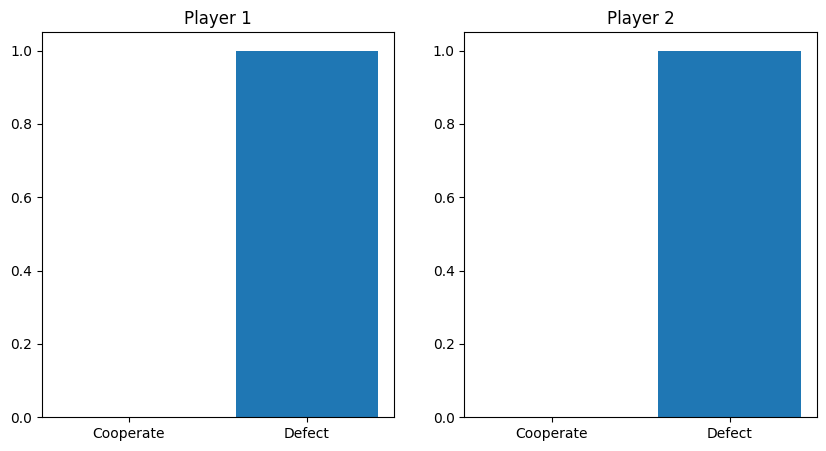

Interrupting ... stopped


In [24]:
# Starting the interactive training
prisoner_optimizer.train(
    limit = 10000, 
    action_labels_1=['Cooperate', 'Defect'], 
    action_labels_2=['Cooperate', 'Defect']
)

As you can see, it converges pretty quicky to the optimal value in this case
Let us see what happens if we use the iterative trainer on a case where no
deterministic nash equilibrium exists

In [25]:
class Same(DiscreteGamePlayer):
    """Wants to choose the same value as the other player"""
    def __init__(self):
        super().__init__(2, 2)
    def payout(self, move1: int, move2: int) -> float:
        if move1 == move2:
            return 1.0
        else:
            return -1.0
class Different(DiscreteGamePlayer):
    """Wants to choose a different value to the other player"""
    def __init__(self):
        super().__init__(2, 2)
    def payout(self, move1: int, move2: int) -> float:
        if move1 == move2:
            return -1.0
        else:
            return 1.0

In [26]:
same_different_trainer = DiscreteIterativeTrainer(Same(), Different())

epoch = 6600
Interrupting ...

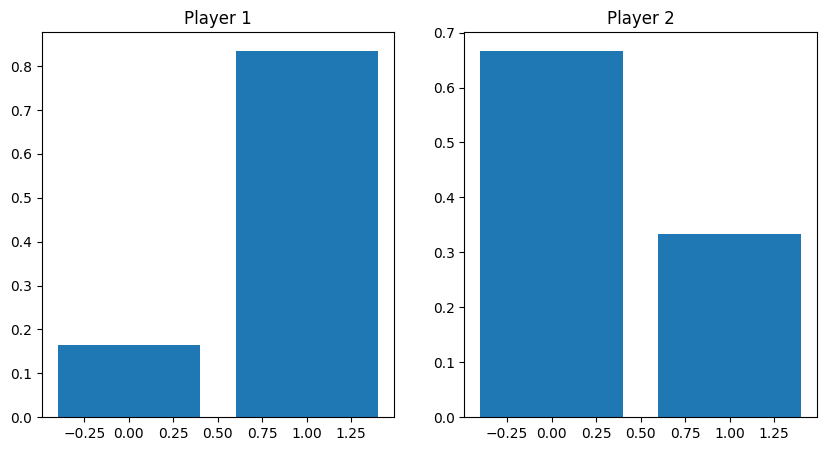

 stopped


In [27]:
same_different_trainer.train()

As you can see, unfortunately, this does not converge to the nash equilibrium
DiscreteIterativeTrainer is guaranteed to converge to a deterministic nash equilibrium
if one exists
However, it is not good at finding non deterministic ones

To solve this, I have implemented DiscreteLossTrainer, which minimizes a loss function that
represents the deviation from the nash equilibrium position.

In [28]:
same_different_trainer = DiscreteLossTrainer(Same(), Different())

epoch = 1400
loss = 0.00034177303314208984


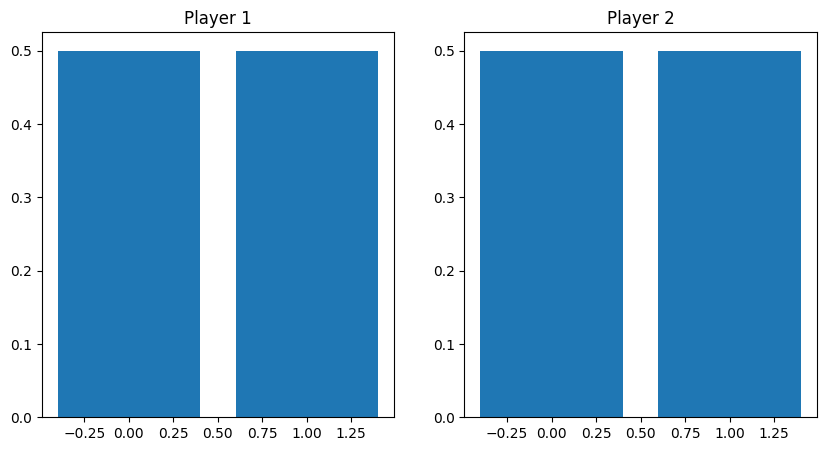

Interrupting ... stopped


In [29]:
same_different_trainer.train()

Trying a more complicated example.

In [30]:
# Discrete version of jane street's problem
class NumberBidder(DiscreteGamePlayer):
  def __init__(self):
    super().__init__(101, 101)
  def payout(self, move1: int, move2: int) -> float:
    if move1 < move2:
      return move1
    else:
      # Assuming the uniform variable chooses a continuous value
      prob_lose = (move1) / 100
      prob_win = 1 - prob_lose
      payout = prob_win * move1 + prob_lose * (-move2 - move1 / 2)
      return payout

In [31]:
jane_trainer = DiscreteLossTrainer(NumberBidder(), NumberBidder())

epoch = 18800
loss = 0.03536224365234375


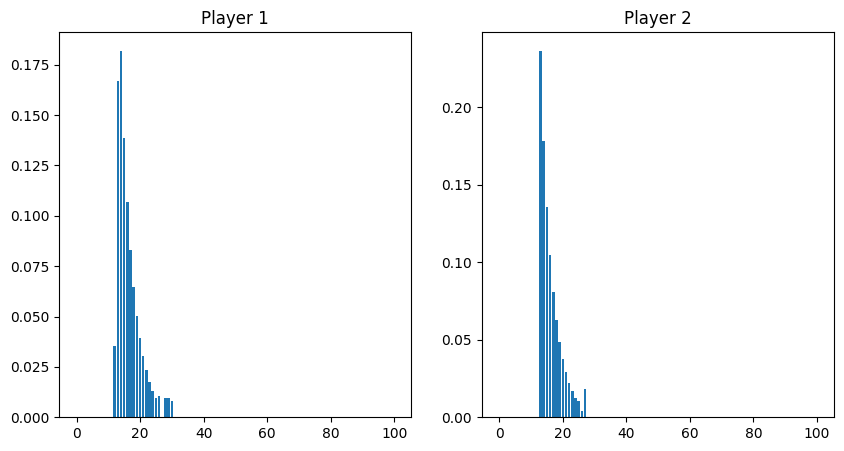

Interrupting ... stopped


In [32]:
jane_trainer.train(limit = 60000)

As you can see, this works extremely well